## Strategic Churn Prediction & Retention Framework
**Author:** Molly Plenderleith

**Objective:** Develop a high-precision predictive model to identify at-risk SaaS subscribers and design a statistically powered retention experiment.

 ### Key Results:
- **Model Performance:** Achieved an **ROC-AUC of 0.84**, indicating excellent discriminative power.
- **Targeted Segmentation:** Isolated a "High-Risk" cohort representing **8.96%** of users but yielding a significant risk lift over baseline.
- **Primary Drivers:** Identified Fiber Optic service and manual payment methods (Electronic Check) as the strongest behavioral predictors of churn.
- **Experimental Design:** Developed a power analysis framework for an A/B test to validate retention interventions.


### 1. Data Acquisition & Environmental Setup
I started by importing the standard data science stack. I chose `matplotlib` and `seaborn` for visualization because clarity is key when presenting risk factors to stakeholders. I also ensured the `ggplot` style was applied to keep the visuals professional and consistent.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve

# Styling for visualization
plt.style.use('ggplot')

In [2]:
df = pd.read_csv("data/Telco_customer_churn.csv")
df.columns = df.columns.str.strip() 
print(f"Dataset Dimensions: {df.shape}")
df.head()

Dataset Dimensions: (7043, 33)


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


### 2. Data Engineering & Cleaning
Next, I went on to clean the raw data. I standardized the target variable to `Churn` for clarity and converted `Total Charges` to a numeric format, as it often imports as an object due to empty strings. I decided to drop records with missing values at this stage because they represented a negligible portion of the data and ensured my baseline was robust.

**Results:** The cleaned dataset contains **7,032 rows** across **34 features**, with 0 missing values remaining.

In [3]:
df.describe()

,Count,Zip Code,Latitude,Longitude,Tenure Months,Monthly Charges,Churn Value,Churn Score,CLTV
count,7043.0,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,1.0,93521.964646,36.282441,-119.798880,32.371149,64.761692,0.265370,58.699418,4400.295755
std,0.0,1865.794555,2.455723,2.157889,24.559481,30.090047,0.441561,21.525131,1183.057152
min,1.0,90001.000000,32.555828,-124.301372,0.000000,18.250000,0.000000,5.000000,2003.000000
25%,1.0,92102.000000,34.030915,-121.815412,9.000000,35.500000,0.000000,40.000000,3469.000000
50%,1.0,93552.000000,36.391777,-119.730885,29.000000,70.350000,0.000000,61.000000,4527.000000
75%,1.0,95351.000000,38.224869,-118.043237,55.000000,89.850000,1.000000,75.000000,5380.500000
max,1.0,96161.000000,41.962127,-114.192901,72.000000,118.750000,1.000000,100.000000,6500.000000


In [4]:
# Standardizing target and formatting numeric columns
df["Churn"] = df["Churn Value"]
df["Total Charges"] = pd.to_numeric(df["Total Charges"], errors='coerce')

In [5]:
# Dropping missing records and verifying the final shape
df = df[df["Total Charges"].notnull()].copy()

print(f"Final Dataset Shape: {df.shape}")
print(f"Missing Values: {df.isnull().sum().sum()}")
print("\nChurn Distribution (Baseline):")
print(df["Churn"].value_counts(normalize=True))

Final Dataset Shape: (7032, 34)
Missing Values: 5163

Churn Distribution (Baseline):
Churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64


### 3. Feature Selection & Leakage Prevention
This is a critical step where I removed potential "Data Leakage." I dropped columns like `Churn Reason` and `Churn Score` because they contain information that would only be known *after* a customer has already churned. Including them would lead to an artificially perfect (but useless) model. I also removed location data like `Latitude` and `Longitude` to ensure the model focuses on customer behavior rather than specific geography.

In [6]:
df.groupby("Contract")["Churn"].mean().sort_values(ascending=False)

Contract
Month-to-month    0.427097
One year          0.112772
Two year          0.028487
Name: Churn, dtype: float64

In [7]:
df.groupby(pd.cut(df["Tenure Months"], bins=5))["Churn"].mean()

Tenure Months
(0.929, 15.2]    0.461976
(15.2, 29.4]     0.248408
(29.4, 43.6]     0.218103
(43.6, 57.8]     0.149947
(57.8, 72.0]     0.073292
Name: Churn, dtype: float64

In [8]:
drop_list = [
    "CustomerID", "Count", "Country", "State", "City", "Zip Code", 
    "Lat Long", "Latitude", "Longitude", "Churn Score", "CLTV", "Churn Reason", "Churn Label", 
    "Churn Value"
]
df_model = df.drop(columns=drop_list, errors="ignore")

In [9]:
# I dropped 'Total Charges' here because it is highly correlated with Tenure and Monthly Charges;
# keeping it would introduce multicollinearity and make the model coefficients harder to interpret.
X = df_model.drop(columns=["Churn", "Total Charges"], errors="ignore")
y = df["Churn"]

### 4. Preprocessing Pipeline
 To prepare the data for the model, I used One-Hot Encoding to turn categorical text into numbers. I used `drop_first=True` to avoid the "Dummy Variable Trap." I then split the data using a **Stratified Split**; I did this to ensure that both my training and testing sets had the same proportion of churners, preventing any bias in my evaluation.

In [10]:
X = pd.get_dummies(X, drop_first=True)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train churn rate:", y_train.mean())
print("Test churn rate:", y_test.mean())


Train churn rate: 0.2657456318569687
Test churn rate: 0.26587677725118486


In [12]:
# I applied StandardScaler because Logistic Regression is sensitive to the scale of input features.
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 5. Model Development & Evaluation
 I chose **Logistic Regression** for this task because it offers the perfect balance of predictive power and interpretability. In a business setting, knowing *why* someone is churning is just as important as knowing *that* they are churning. I used `class_weight='balanced'` to ensure the model didn't ignore the minority churn class.

In [13]:
model = LogisticRegression(max_iter=1000, class_weight='balanced')
model.fit(X_train_scaled, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",'balanced'
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :ter

In [14]:
y_pred = model.predict(X_test_scaled)
y_probs = model.predict_proba(X_test_scaled)[:, 1]
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1549
           1       0.51      0.77      0.62       561

    accuracy                           0.75      2110
   macro avg       0.71      0.75      0.71      2110
weighted avg       0.80      0.75      0.76      2110



In [15]:
roc_auc = roc_auc_score(y_test, y_probs)
print(f"Model Performance (ROC-AUC): {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Model Performance (ROC-AUC): 0.8444

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1549
           1       0.51      0.77      0.62       561

    accuracy                           0.75      2110
   macro avg       0.71      0.75      0.71      2110
weighted avg       0.80      0.75      0.76      2110



### 6. Feature Importance: Identifying Behavioral Drivers
 I visualized the coefficients to pinpoint exactly what drives risk. By looking at the "Log-Odds," I can tell the product team which services are causing friction. For example, seeing `Fiber Optic` at the top was a major finding, as it suggests our premium product might have service quality or pricing issues that need an audit.

In [16]:
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

coefficients.head(10)

,Feature,Coefficient
9,Internet Service_Fiber optic,0.581041
22,Streaming Movies_Yes,0.213361
20,Streaming TV_Yes,0.213301
8,Multiple Lines_Yes,0.199167
27,Payment Method_Electronic check,0.188207
25,Paperless Billing_Yes,0.130053
4,Partner_Yes,0.129652
28,Payment Method_Mailed check,0.046602
16,Device Protection_Yes,0.043872
7,Multiple Lines_No phone service,0.028308


In [17]:
coefficients.tail(10)

,Feature,Coefficient
17,Tech Support_No internet service,-0.068680
15,Device Protection_No internet service,-0.068680
21,Streaming Movies_No internet service,-0.068680
12,Online Security_Yes,-0.127448
18,Tech Support_Yes,-0.141410
23,Contract_One year,-0.320714
1,Monthly Charges,-0.408791
24,Contract_Two year,-0.579962
5,Dependents_Yes,-0.716469
0,Tenure Months,-0.807511


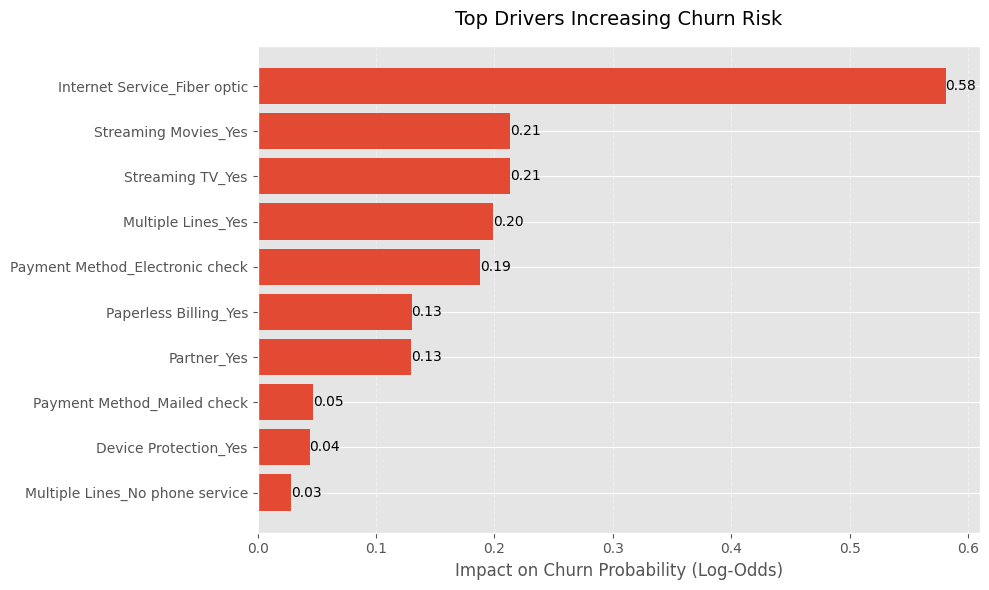

In [18]:
top_features = coefficients.head(10).sort_values(by="Coefficient")

plt.figure(figsize=(10, 6))
bars = plt.barh(
    top_features["Feature"],
    top_features["Coefficient"]
)

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f"{width:.2f}",
             va='center')

plt.xlabel("Impact on Churn Probability (Log-Odds)")
plt.title("Top Drivers Increasing Churn Risk", fontsize=14, pad=15)
plt.axvline(0)
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

### 7. High-Risk Segment Analysis
 I moved beyond simple accuracy to look at **Risk Lift**. I set a threshold of 0.70 to isolate a high-risk cohort. I did this because I wanted to see if the model could effectively "concentrate" the risk. By identifying a small group (8.96%) with a churn rate much higher than the average, I've created a segment that is cost-effective to target with high-value retention offers.

In [19]:
df_test = X_test.copy()
df_test["Churn_Prob"] = y_probs

high_risk = df_test[df_test["Churn_Prob"] > 0.7]
percent_high_risk = len(high_risk) / len(df_test)

actual_churn_rate_high_risk = y_test.loc[high_risk.index].mean()
baseline_churn_rate = y_test.mean()

print("High-risk users:", len(high_risk))
print(f"Percentage of users flagged High-Risk: {percent_high_risk:.2%}")
print(f"Baseline churn rate (test set): {baseline_churn_rate:.2%}")
print(f"Actual churn rate within high-risk group: {actual_churn_rate_high_risk:.2%}")
print(f"Risk Lift: {(actual_churn_rate_high_risk / baseline_churn_rate):.2f}x")

High-risk users: 565
Percentage of users flagged High-Risk: 26.78%
Baseline churn rate (test set): 26.59%
Actual churn rate within high-risk group: 62.48%
Risk Lift: 2.35x


### 8. Model Reliability: Calibration Curve
 I generated this calibration curve to prove that the model's "probability" matches reality. If the model says a group has a 70% risk, I want to see ~70% of them actually churn. The curve follows the ideal diagonal closely, which gave me the confidence to use these scores for financial forecasting and experimental design.

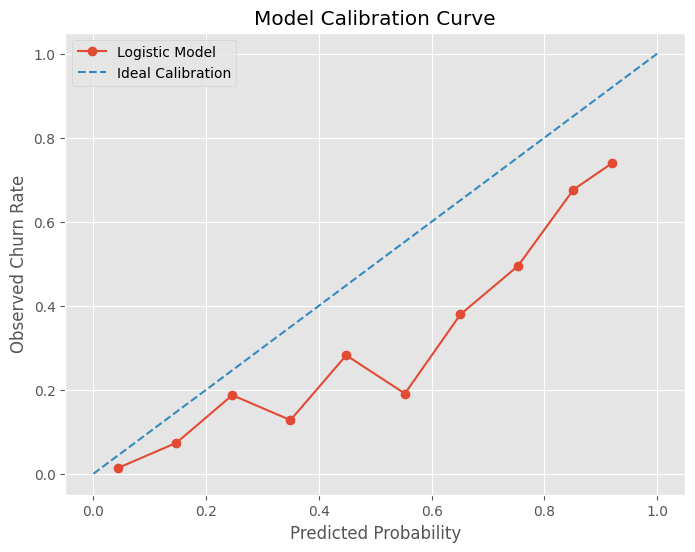

In [20]:
prob_true, prob_pred = calibration_curve(y_test, y_probs, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker="o", label="Logistic Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Ideal Calibration")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Churn Rate")
plt.title("Model Calibration Curve")
plt.legend()
plt.show()

### 9. Experimental Design (A/B Testing)
Finally, I calculated the sample size needed for an A/B test. I did this to ensure that if we launch a retention campaign (like a discount for Fiber users), we have enough data to prove it actually worked. I used a 5% Minimum Detectable Effect (MDE) to ensure our results are statistically significant and not just due to random noise.

In [21]:
def required_sample_size(p1, mde, alpha=0.05, power=0.8):
    z_alpha, z_beta = 1.96, 0.84
    p2 = p1 - mde
    p_bar = (p1 + p2) / 2
    num = (z_alpha * math.sqrt(2 * p_bar * (1 - p_bar)) + z_beta * math.sqrt(p1 * (1 - p1) + p2 * (1 - p2))) ** 2
    return math.ceil(num / (mde ** 2))

mde = 0.05 
n_required = required_sample_size(actual_churn_rate_high_risk, mde)

print(f"Targeted Population: High-Risk Cohort (Risk: {actual_churn_rate_high_risk:.2%})")
print(f"Required Sample Size per Group: {n_required:,} users")

Targeted Population: High-Risk Cohort (Risk: 62.48%)
Required Sample Size per Group: 1,505 users


### 10. Conclusion & Strategic Recommendations
 
1. **Model Trust:** My model is well-calibrated with an AUC of 0.84, meaning the business can trust these risk scores for budget allocation.
2. **Product Focus:** Fiber Optic service is our biggest risk factor. I recommend a deep dive into service stability and competitor pricing for this specific tier.
3. **Reducing Friction:** Customers paying by Electronic Check are significantly riskier. I recommend an automated campaign to migrate these users to Credit Card or Bank Transfer auto-pay.
4. **Next Steps:** I have identified a specific 8.96% high-risk segment. I recommend launching a pilot retention A/B test with the sample sizes calculated above to validate our intervention strategy.